In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score,confusion_matrix, recall_score, precision_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble.forest import RandomForestClassifier

import imblearn
from imblearn.over_sampling import SMOTE

import warnings; warnings.simplefilter('ignore')

Using TensorFlow backend.


## Conditioning

In [35]:
df = pd.read_csv('Crime_data_final.csv')

In [37]:
df.head()

,Unnamed: 0,REPORT_DAT,SHIFT,METHOD,OFFENSE,WARD,DISTRICT,NEIGHBORHOOD_CLUSTER,BLOCK_GROUP,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,OBJECTID,OCTO_RECORD_ID,COUNT,CITY,STATE,DATE,TIME
0,0,2018-12-22T21:10:50.000Z,EVENING,OTHERS,THEFT/OTHER,4,4.0,Cluster 18,002301 2,2301.0,Precinct 45,38.942182,-77.014557,329684676,18217166-01,1,"Washington, DC",District of Columbia,2018-12-22,21:10:50
1,1,2018-12-22T20:29:36.000Z,EVENING,OTHERS,THEFT/OTHER,6,1.0,Cluster 27,007200 2,7200.0,Precinct 131,38.876999,-77.004356,329684677,18217171-01,1,"Washington, DC",District of Columbia,2018-12-22,20:29:36
2,2,2018-12-23T03:38:37.000Z,MIDNIGHT,OTHERS,THEFT/OTHER,7,6.0,Cluster 32,009603 3,9603.0,Precinct 102,38.890214,-76.952775,329684678,18217172-01,1,"Washington, DC",District of Columbia,2018-12-23,03:38:37
3,3,2018-12-22T21:00:57.000Z,EVENING,OTHERS,MOTOR VEHICLE THEFT,7,6.0,Cluster 33,007803 3,7803.0,Precinct 98,38.890241,-76.935370,329684679,18217180-01,1,"Washington, DC",District of Columbia,2018-12-22,21:00:57
4,4,2018-12-22T20:49:59.000Z,EVENING,OTHERS,THEFT F/AUTO,2,1.0,Cluster 8,005800 2,5800.0,Precinct 129,38.900860,-77.020912,329684680,18217182-01,1,"Washington, DC",District of Columbia,2018-12-22,20:49:59


In [5]:
df = df.drop(columns = ['Unnamed: 0', 'COUNT', 'CITY', 'STATE', 'REPORT_DAT', 'OCTO_RECORD_ID'])

Splitting our X and Y variables:

In [6]:
y = df.OFFENSE
df = df.drop(columns = 'OFFENSE')

Some of our feature variables include text data. We'll need to split these columns and include only the integer values:

In [7]:
df['NEIGHBORHOOD_CLUSTER'] = df['NEIGHBORHOOD_CLUSTER'].str.split(' ').str[1]
df['VOTING_PRECINCT'] = df['VOTING_PRECINCT'].str.split(' ').str[1]

Further, we'll isolate our data and time features by their component parts (i.e., day, month, year):

In [8]:
df['YEAR'] = df['DATE'].str.split('-').str[0]
df['MONTH'] = df['DATE'].str.split('-').str[1]
df['DAY'] = df['DATE'].str.split('-').str[2]

df['HOUR'] = df['TIME'].str.split(':').str[0]
df['MINUTE'] = df['TIME'].str.split(':').str[1]
df['SECOND'] = df['TIME'].str.split(':').str[2]

In [9]:
df = df.drop(columns = ['DATE', 'TIME'])

Next we'll strip any white space for some of our features: 

In [10]:
df['BLOCK_GROUP'] = df['BLOCK_GROUP'].str.replace(" ","")

And convert the string variables to integers:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53654 entries, 0 to 53653
Data columns (total 17 columns):
SHIFT                   53654 non-null object
METHOD                  53654 non-null object
WARD                    53654 non-null int64
DISTRICT                53654 non-null float64
NEIGHBORHOOD_CLUSTER    53654 non-null object
BLOCK_GROUP             53654 non-null object
CENSUS_TRACT            53654 non-null float64
VOTING_PRECINCT         53654 non-null object
LATITUDE                53654 non-null float64
LONGITUDE               53654 non-null float64
OBJECTID                53654 non-null int64
YEAR                    53654 non-null object
MONTH                   53654 non-null object
DAY                     53654 non-null object
HOUR                    53654 non-null object
MINUTE                  53654 non-null object
SECOND                  53654 non-null object
dtypes: float64(4), int64(2), object(11)
memory usage: 7.0+ MB


In [12]:
df['DISTRICT'] = df['DISTRICT'].astype(int)
df['NEIGHBORHOOD_CLUSTER'] = df['NEIGHBORHOOD_CLUSTER'].astype(int)
df['BLOCK_GROUP'] = df['BLOCK_GROUP'].astype(int)
df['VOTING_PRECINCT'] = df['VOTING_PRECINCT'].astype(int)
df['DISTRICT'] = df['DISTRICT'].astype(int)

df['YEAR'] = df['YEAR'].astype(int)
df['MONTH'] = df['MONTH'].astype(int)
df['DAY'] = df['DAY'].astype(int)

df['HOUR'] = df['HOUR'].astype(int)
df['MINUTE'] = df['MINUTE'].astype(int)
df['SECOND'] = df['SECOND'].astype(int)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53654 entries, 0 to 53653
Data columns (total 17 columns):
SHIFT                   53654 non-null object
METHOD                  53654 non-null object
WARD                    53654 non-null int64
DISTRICT                53654 non-null int64
NEIGHBORHOOD_CLUSTER    53654 non-null int64
BLOCK_GROUP             53654 non-null int64
CENSUS_TRACT            53654 non-null float64
VOTING_PRECINCT         53654 non-null int64
LATITUDE                53654 non-null float64
LONGITUDE               53654 non-null float64
OBJECTID                53654 non-null int64
YEAR                    53654 non-null int64
MONTH                   53654 non-null int64
DAY                     53654 non-null int64
HOUR                    53654 non-null int64
MINUTE                  53654 non-null int64
SECOND                  53654 non-null int64
dtypes: float64(3), int64(12), object(2)
memory usage: 7.0+ MB


## Feature Engineering

The first piece of our feature engineering phase requires us to address the categorical features from the 'shift' and 'method' columns. We'll address this by dummifying the columns:

In [14]:
df.SHIFT.unique()

array(['EVENING', 'MIDNIGHT', 'DAY'], dtype=object)

In [15]:
df.METHOD.unique()

array(['OTHERS', 'GUN', 'KNIFE'], dtype=object)

In [16]:
df = pd.get_dummies(df)

In [17]:
print('Final feature dataset shape:',df.shape)
print()
display(df.head())

Final feature dataset shape: (53654, 21)



,WARD,DISTRICT,NEIGHBORHOOD_CLUSTER,BLOCK_GROUP,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,OBJECTID,YEAR,...,DAY,HOUR,MINUTE,SECOND,SHIFT_DAY,SHIFT_EVENING,SHIFT_MIDNIGHT,METHOD_GUN,METHOD_KNIFE,METHOD_OTHERS
0,4,4,18,23012,2301.0,45,38.942182,-77.014557,329684676,2018,...,22,21,10,50,0,1,0,0,0,1
1,6,1,27,72002,7200.0,131,38.876999,-77.004356,329684677,2018,...,22,20,29,36,0,1,0,0,0,1
2,7,6,32,96033,9603.0,102,38.890214,-76.952775,329684678,2018,...,23,3,38,37,0,0,1,0,0,1
3,7,6,33,78033,7803.0,98,38.890241,-76.935370,329684679,2018,...,22,21,0,57,0,1,0,0,0,1
4,2,1,8,58002,5800.0,129,38.900860,-77.020912,329684680,2018,...,22,20,49,59,0,1,0,0,0,1


Next, we'll assign numerical values to each of our target variables: 

In [18]:
print('Number of offense categories:',y.nunique())
print()
print('Frequency of each offense category:')
print()
print(y.value_counts())

Number of offense categories: 9

Frequency of each offense category:

THEFT/OTHER                   23219
THEFT F/AUTO                  17917
MOTOR VEHICLE THEFT            3695
ROBBERY                        3319
ASSAULT W/DANGEROUS WEAPON     2634
BURGLARY                       2210
SEX ABUSE                       389
HOMICIDE                        261
ARSON                            10
Name: OFFENSE, dtype: int64


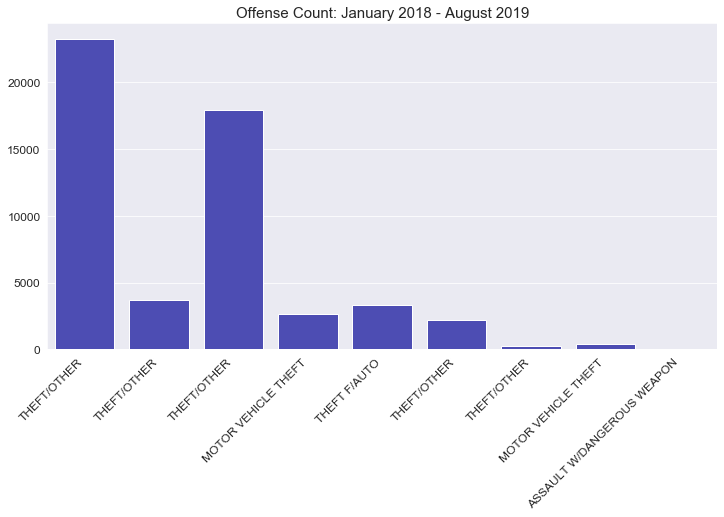

In [19]:
sns.set_style('darkgrid')

plt.figure(figsize= (12,6))

g = sns.countplot(x = y, color = 'b', saturation=.4)
g.set_xticklabels(rotation = 45, labels = y, horizontalalignment='right')

plt.title('Offense Count: January 2018 - August 2019', size = 15)
plt.ylabel('')
plt.xlabel('')
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.show()

Based on the extreme imbalance of our target variable, we'll need to employ some rebalancing using the SMOTE method. Before doing so, let's convert our target variable to integers:

In [20]:
y_labels = y

In [21]:
y = y.astype('category')
encoded_labels = y.cat.codes
encoded_labels.head()

0    8
1    8
2    8
3    4
4    7
dtype: int8

We'll align our encoded labels and label strings in a variable for later model performance analysis:

In [22]:
label_ints = encoded_labels.unique()
labels = y_labels.unique()

labels = np.column_stack((label_ints, labels))
print(labels)

[[8 'THEFT/OTHER']
 [4 'MOTOR VEHICLE THEFT']
 [7 'THEFT F/AUTO']
 [1 'ASSAULT W/DANGEROUS WEAPON']
 [5 'ROBBERY']
 [2 'BURGLARY']
 [3 'HOMICIDE']
 [6 'SEX ABUSE']
 [0 'ARSON']]


In [24]:
test_df = df
test_df['TARGET'] = y

In [ ]:
test_df.to_csv('Model_test_data.csv')

With our labels encoded, we can move on to rebalancing the dataset: 

In [ ]:
y = encoded_labels
df.drop(columns = 'TARGET', inplace = True)
x = df

In [ ]:
print('Target value counts pre resampling:')
print(y.value_counts())
print()

x_resampled, y_resampled = SMOTE().fit_sample(x,y)

print('Target value counts post resampling:')
print(pd.Series(y_resampled).value_counts())

resampled_feats = pd.DataFrame(x_resampled, columns = df.columns)
target = y_resampled

In [ ]:
print('Number of instances in our feature set:', len(resampled_feats))
print('Number of labels in our target set:', len(target))

As a last measure in the feature engineering phase, we'll employ the Standard Scaler function from SKlearn to achieve a uniform scale of our data. We'll do this to avoid outsized impacts certain features may have on our classification models:

In [ ]:
resampled_feats.head()

In [ ]:
column_names = resampled_feats.columns

scaler = StandardScaler()
scaled_feats = scaler.fit_transform(resampled_feats)

scaled_feats = pd.DataFrame(scaled_feats, columns = column_names)

features = scaled_feats
features.head()

Before finishing this section, we're going to combine our features and target data in one dataframe and save the file as a CSV for easy access down the road:

In [ ]:
features['TARGET'] = target

In [ ]:
features.to_csv('Modeling_data_final.csv')

## Modeling

With the data prepped for modeling, we'll load in the modeling data, split our target and features, and split our train and test set:

In [38]:
df = pd.read_csv('Modeling_data_final.csv')
features = df.drop(columns = ['TARGET', 'Unnamed: 0'])
target = df.TARGET

In [39]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = .20)

In [ ]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))

seed = 42
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    
    kfold = model_selection.KFold(n_splits = 20, random_state = seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv = kfold, scoring = scoring)
    
    results.append(cv_results)
    names.append(name)
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    
    print(msg)

In [ ]:
plt.figure(figsize=(6,8))
plt.boxplot(results, labels=names )
plt.title('Algorithm Comparison')
plt.show()

Based on the above results, it's clear the random forest algorithm yields the best results with respect to accuracy scores. Our next step is to run a grid search using varying random forest hyper parameters in an attempt to flush out the best final model: 

In [ ]:
param_grid = { 
    'n_estimators': [50, 100, 150],
    'max_depth' : [5, 15, 30],
    'min_samples_leaf' : [1, 5, 10],
    'criterion' : ['gini', 'entropy']
}

In [ ]:
rfc = RandomForestClassifier(random_state = 42)

In [ ]:
CV_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 3)
CV_rfc.fit(X_train, y_train)

In [ ]:
print('Optimal hyperparameters for max accuracy score:', CV_rfc.best_params_)

With the retrieval of the best parameters, let's re-run the algorithm and test the model against our testing set: 

In [40]:
rfc = RandomForestClassifier(random_state = 42, criterion = 'gini', max_depth = 30, 
                             min_samples_leaf = 1, n_estimators = 150, verbose = 0)
trained_model = rfc.fit(X_train, y_train)

In [41]:
predictions = trained_model.predict(X_test)

In [42]:
print('Random Forest model accuracy: ', accuracy_score(y_test, predictions))

Random Forest model accuracy:  0.862208398133748


We'll take a look at the confusion matrix produced by our models predictions on the test set: 

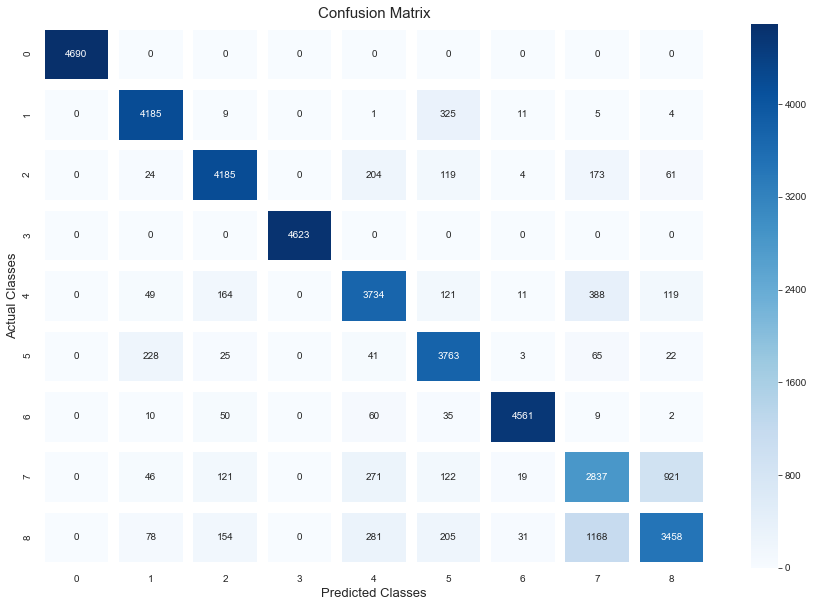

In [43]:
cnf_matrix = confusion_matrix(predictions, y_test)

plt.figure(figsize=(15,10))
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap= 'Blues', linewidths=10, )
plt.title('Confusion Matrix', size= 15)
plt.xlabel('Predicted Classes', size = 13)
plt.ylabel('Actual Classes', size = 13)

plt.show()

With our test accuracy at ~86%, we'll take a look at the features of most importance in determining the type of crime that took place:

In [44]:
feature_importances = pd.Series(trained_model.feature_importances_, 
                                index = features.columns).sort_values(ascending = False)
feature_importances

SECOND                  0.099928
MINUTE                  0.084167
HOUR                    0.072718
OBJECTID                0.069355
LONGITUDE               0.068454
METHOD_OTHERS           0.056059
LATITUDE                0.054586
BLOCK_GROUP             0.053842
MONTH                   0.050696
CENSUS_TRACT            0.050082
DAY                     0.047766
VOTING_PRECINCT         0.042667
NEIGHBORHOOD_CLUSTER    0.033668
METHOD_GUN              0.031204
SHIFT_MIDNIGHT          0.028982
DISTRICT                0.028745
YEAR                    0.027620
WARD                    0.027134
SHIFT_EVENING           0.025848
METHOD_KNIFE            0.023905
SHIFT_DAY               0.022573
dtype: float64

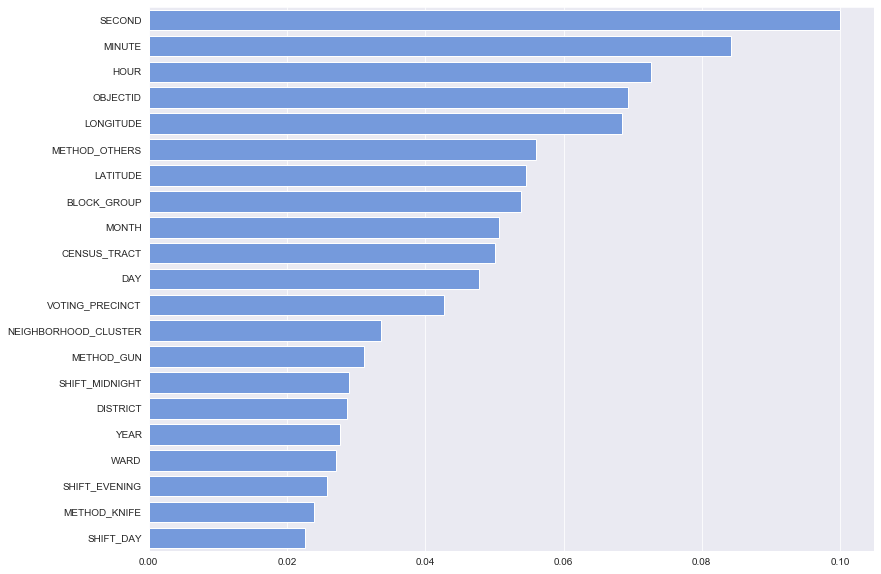

In [45]:
plt.figure(figsize=(13,10))

sns.barplot(x = feature_importances, y = feature_importances.index, color = 'cornflowerblue')
plt.show()


With our model trained, let's run some predictions on data yet to be seen:

In [56]:
test_df = pd.read_csv('Model_test_data.csv')
test_df.drop(columns = 'Unnamed: 0', inplace = True)
test_df.head()

,WARD,DISTRICT,NEIGHBORHOOD_CLUSTER,BLOCK_GROUP,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,OBJECTID,YEAR,...,HOUR,MINUTE,SECOND,SHIFT_DAY,SHIFT_EVENING,SHIFT_MIDNIGHT,METHOD_GUN,METHOD_KNIFE,METHOD_OTHERS,TARGET
0,4,4,18,23012,2301.0,45,38.942182,-77.014557,329684676,2018,...,21,10,50,0,1,0,0,0,1,THEFT/OTHER
1,6,1,27,72002,7200.0,131,38.876999,-77.004356,329684677,2018,...,20,29,36,0,1,0,0,0,1,THEFT/OTHER
2,7,6,32,96033,9603.0,102,38.890214,-76.952775,329684678,2018,...,3,38,37,0,0,1,0,0,1,THEFT/OTHER
3,7,6,33,78033,7803.0,98,38.890241,-76.935370,329684679,2018,...,21,0,57,0,1,0,0,0,1,MOTOR VEHICLE THEFT
4,2,1,8,58002,5800.0,129,38.900860,-77.020912,329684680,2018,...,20,49,59,0,1,0,0,0,1,THEFT F/AUTO


In [60]:
test_df.YEAR.unique()

array([2018, 2019])

In [61]:
test_df_july19 = test_df.where((test_df['YEAR'] == 2019) & (test_df['MONTH'] == 7))

In [65]:
test_df_july19.dropna(inplace = True)

In [67]:
len(test_df_july19)

2971

In [70]:
test_target = test_df_july19['TARGET']
test_df_july19.drop(columns = 'TARGET', inplace = True)
test_df_july19.head()

,WARD,DISTRICT,NEIGHBORHOOD_CLUSTER,BLOCK_GROUP,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,OBJECTID,YEAR,...,DAY,HOUR,MINUTE,SECOND,SHIFT_DAY,SHIFT_EVENING,SHIFT_MIDNIGHT,METHOD_GUN,METHOD_KNIFE,METHOD_OTHERS
34913,7.0,6.0,31.0,78091.0,7809.0,94.0,38.902325,-76.925456,330095143.0,2019.0,...,1.0,20.0,32.0,35.0,0.0,1.0,0.0,0.0,0.0,1.0
34914,2.0,3.0,6.0,43001.0,4300.0,141.0,38.917000,-77.035515,330095144.0,2019.0,...,1.0,21.0,5.0,16.0,0.0,1.0,0.0,0.0,0.0,1.0
34915,3.0,2.0,11.0,10011.0,1001.0,31.0,38.959907,-77.085300,330095145.0,2019.0,...,1.0,20.0,44.0,22.0,0.0,1.0,0.0,0.0,0.0,1.0
34916,6.0,5.0,23.0,79014.0,7901.0,81.0,38.899608,-76.980391,330095146.0,2019.0,...,1.0,23.0,14.0,53.0,0.0,0.0,1.0,0.0,0.0,1.0
34917,5.0,5.0,21.0,92041.0,9204.0,74.0,38.925590,-77.001511,330095147.0,2019.0,...,1.0,22.0,13.0,42.0,0.0,1.0,0.0,0.0,0.0,1.0


In [86]:
column_names = test_df_july19.columns

scaler = StandardScaler()
scaled_feats = scaler.fit_transform(test_df_july19)

scaled_feats = pd.DataFrame(scaled_feats, columns = column_names)

test_df_july19_scaled = scaled_feats
test_df_july19_scaled.head()

,WARD,DISTRICT,NEIGHBORHOOD_CLUSTER,BLOCK_GROUP,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,OBJECTID,YEAR,...,DAY,HOUR,MINUTE,SECOND,SHIFT_DAY,SHIFT_EVENING,SHIFT_MIDNIGHT,METHOD_GUN,METHOD_KNIFE,METHOD_OTHERS
0,1.205174,1.321071,1.227508,0.496275,0.496298,0.580079,-0.210278,2.371945,-2.815301,0.0,...,-1.778509,1.017703,0.123532,0.362599,-0.722516,1.193033,-0.56867,-0.240149,-0.130834,0.277199
1,-0.989073,-0.310227,-0.955496,-0.617281,-0.617251,1.681841,0.296280,-0.721998,-2.815293,0.0,...,-1.778509,1.166341,-1.437735,-0.729047,-0.722516,1.193033,-0.56867,-0.240149,-0.130834,0.277199
2,-0.550224,-0.853993,-0.518895,-1.664195,-1.664158,-0.896752,1.777395,-2.121517,-2.815285,0.0,...,-1.778509,1.017703,0.817428,-0.384317,-0.722516,1.193033,-0.56867,-0.240149,-0.130834,0.277199
3,0.766325,0.777305,0.528947,0.525566,0.525493,0.275336,-0.304044,0.827648,-2.815277,0.0,...,-1.778509,1.463617,-0.917313,1.396791,-0.722516,-0.838200,1.75849,-0.240149,-0.130834,0.277199
4,0.327475,0.777305,0.354306,0.938969,0.938988,0.111244,0.592805,0.233927,-2.815269,0.0,...,-1.778509,1.314979,-0.975137,0.764785,-0.722516,1.193033,-0.56867,-0.240149,-0.130834,0.277199


In [80]:
test_predictions = trained_model.predict(test_df_july19)

In [85]:
test_predictions = pd.Series(test_predictions)

In [83]:
labels

array([[8, 'THEFT/OTHER'],
       [4, 'MOTOR VEHICLE THEFT'],
       [7, 'THEFT F/AUTO'],
       [1, 'ASSAULT W/DANGEROUS WEAPON'],
       [5, 'ROBBERY'],
       [2, 'BURGLARY'],
       [3, 'HOMICIDE'],
       [6, 'SEX ABUSE'],
       [0, 'ARSON']], dtype=object)